# Imports

In [2]:
import pytorch_tools as pt
from pytorch_tools.utils import rle
import matplotlib.pyplot as plt
import numpy as np
import pydicom
import os
import glob
import pandas as pd
from ipywidgets import interactive, interact
import cv2
from tqdm import tqdm_notebook
import tqdm
from multiprocessing import Pool
from sklearn.model_selection import train_test_split
%matplotlib inline


# Data visualiziation

In [3]:
def show_dcm_info(dataset):
    print("Filename.........:", file_path)
    print("Storage type.....:", dataset.SOPClassUID)
    print()

    pat_name = dataset.PatientName
    display_name = pat_name.family_name + ", " + pat_name.given_name
    print("Patient's name......:", display_name)
    print("Patient id..........:", dataset.PatientID)
    print("Patient's Age.......:", dataset.PatientAge)
    print("Patient's Sex.......:", dataset.PatientSex)
    print("Modality............:", dataset.Modality)
    print("Body Part Examined..:", dataset.BodyPartExamined)
    print("View Position.......:", dataset.ViewPosition)
    
    if 'PixelData' in dataset:
        rows = int(dataset.Rows)
        cols = int(dataset.Columns)
        print("Image size.......: {rows:d} x {cols:d}, {size:d} bytes".format(
            rows=rows, cols=cols, size=len(dataset.PixelData)))
        if 'PixelSpacing' in dataset:
            print("Pixel spacing....:", dataset.PixelSpacing)

def plot_pixel_array(dataset, figsize=(6,6)):
    plt.figure(figsize=figsize)
    plt.imshow(dataset.pixel_array, cmap=plt.cm.bone)
    plt.show()

def mask2rle(img, width, height):
    rle = []
    lastColor = 0;
    currentPixel = 0;
    runStart = -1;
    runLength = 0;

    for x in range(width):
        for y in range(height):
            currentColor = img[x][y]
            if currentColor != lastColor:
                if currentColor == 255:
                    runStart = currentPixel;
                    runLength = 1;
                else:
                    rle.append(str(runStart));
                    rle.append(str(runLength));
                    runStart = -1;
                    runLength = 0;
                    currentPixel = 0;
            elif runStart > -1:
                runLength += 1
            lastColor = currentColor;
            currentPixel+=1;

    return " ".join(rle)

def rle2mask(rle, width, height):
    mask= np.zeros(width* height)
    array = np.asarray([int(x) for x in rle.split()])
    starts = array[0::2]
    lengths = array[1::2]

    current_position = 0
    for index, start in enumerate(starts):
        current_position += start
        mask[current_position:current_position+lengths[index]] = 255
        current_position += lengths[index]

    return mask.reshape(width, height)


### show random dcm train file

In [4]:
train_dcms = glob.glob('input/dicom-images-train/*/*/*.dcm')
test_dcms = glob.glob('input/dicom-images-test/*/*/*.dcm')
rles = np.genfromtxt('input/train-rle-filtered.csv', delimiter=', ', dtype=str)[1:]
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
#df = pd.read_csv('input/train-rle.csv', index_col=0, sep=', ')

In [5]:
from pytorch_tools.utils.rle import rle_to_string, rle_encode, rle_decode

In [6]:
# we have more rles than images. need to merge them
# new_rles = []
# for un_idx in tqdm_notebook(np.unique(rles[:, 0])):
#     idx_rles = rles[rles[:,0] == un_idx][:, 1]
#     masks = [rle_decode(rle, (1024,1024), relative=True) for rle in idx_rles]
#     mask = np.clip(np.sum(masks, axis=0), 0,1)
#     new_rle = rle_to_string(rle_encode(mask))
#     new_rle = new_rle if new_rle else '-1'
#     new_rles.append(new_rle)

In [7]:
# with open('input/train-rle-filtered.csv', 'w') as f:
#     lines = [','.join([idx, rle]) for idx, rle in zip(np.unique(rles[:, 0]), new_rles)]
#     result = '\n'.join(lines)
#     f.write(result)
rles = np.genfromtxt('input/train-rle-filtered.csv', delimiter=',', dtype=str)

In [11]:
#np.random.shuffle(train_dcms)
@interact(n=(0,20))
def f(n=4, show_mask=True, use_clahe=False, dilate_mask=False):
    dataset = pydicom.dcmread(train_dcms[n])
    #show_dcm_info(dataset)
    plt.figure(figsize=(5,5))
    pixels = dataset.pixel_array
    if use_clahe:
        pixels = clahe.apply(pixels)
    plt.imshow(pixels, cmap=plt.cm.bone)
    img_id = train_dcms[n].split('/')[-1][:-4]
    try:
        rle_mask = rles[rles[:,0] == img_id][0, 1]
    except:
        rle_mask = '-1'
    if rle_mask != '-1':
        plt.title('See Marker')
        mask = rle_decode(rle_mask, (1024,1024)).astype(np.uint8)
        if show_mask:
            if dilate_mask:
                mask_sz = np.sqrt(np.sum(mask))
                k_sz = int(mask_sz * 0.1)
                kernel = np.ones((k_sz, k_sz))
                mask = cv2.dilate(mask,kernel,iterations = 1)
            pixels[mask == 1] = 255
            plt.imshow(pixels, cmap=plt.cm.bone)
    else:
        plt.title('Nothing to see')
    plt.show()

interactive(children=(IntSlider(value=4, description='n', max=20), Checkbox(value=True, description='show_mask…

## Show masks histograms

In [103]:
def get_mask_size(rles):
    sizes = []
    for rle in rles:
        if rle == '-1':
            sizes.append(0)
            continue
        sizes.append(sum([int(ii) for ii in rle.split()[1::2]]))
    return sizes

Total images: 10675. Has masks: 2379
Max mask/image perc: 15.394306182861328. Min: 0.005245208740234375. Mean: 1.3680423994733788.


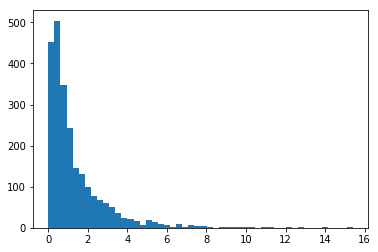

In [104]:
with_mask = rles[rles[:,1] != '-1']
print('Total images: {}. Has masks: {}'.format(len(rles), len(with_mask)))
mask_sizes = get_mask_size(rles[:, 1])
mask_sizes = [i / (1024*1024)*100 for i in mask_sizes if i > 0]
print('Max mask/image perc: {}. Min: {}. Mean: {}.'.format(max(mask_sizes),min(mask_sizes), np.mean(mask_sizes)))
plt.hist(mask_sizes, bins=50);

## Train test val split

In [12]:
train, val_test = train_test_split(rles, stratify=rles[:,1] != '-1', test_size=0.2, random_state=42)
val, test = train_test_split(val_test, stratify=val_test[:,1] != '-1', test_size=0.5, random_state=42)
train_idx = set(train[:,0])
val_idx = set(val[:,0])
test_idx = set(test[:,0])
np.save('workdir/train_idx', train[:,0])
np.save('workdir/test_idx', test[:,0])
np.save('workdir/val_idx', val[:,0])

# Preprocess datasets

In [16]:
# save train images
os.makedirs('workdir/preprocessed_train/images/', exist_ok=True)
os.makedirs('workdir/preprocessed_train/masks/', exist_ok=True)
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
USE_CLAHE = False
DILATE_MASK = False
def save_one(pair):
    idx, dcm = pair
    #filename = '{:06d}.'.format(idx)
    img = pydicom.dcmread(dcm).pixel_array
    img_id = dcm.split('/')[-1][:-4]
    try:
        rle_mask = rles[rles[:,0] == img_id][0, 1]
    except:
        rle_mask = '-1'
    if rle_mask == '-1':
        mask = np.zeros((1024,1024),dtype=np.uint8)
    else:
        #print(rle_mask)
        mask = rle_decode(rle_mask, (1024,1024)).astype(np.uint8)
    #print(np.mean(mask))
    # make images more contrast
    img = clahe.apply(img) if USE_CLAHE else img
    # make masks bigger for easier detection
    if DILATE_MASK:
        mask_sz = np.sqrt(np.sum(mask))
        k_sz = int(mask_sz * 0.05) # dilate by 5% of mask size
        kernel = np.ones((k_sz, k_sz))
        mask = cv2.dilate(mask,kernel,iterations = 1)
    cv2.imwrite('workdir/preprocessed_train/images/'+img_id + '.jpg', img)
    cv2.imwrite('workdir/preprocessed_train/masks/'+img_id + '.png', mask) #PNG for masks!

pairs = list(zip(list(range(len(train_dcms))), train_dcms))
with Pool() as pool:
    for _ in tqdm_notebook(pool.imap_unordered(save_one, pairs), total=len(pairs)):
        pass

In [24]:
sizes = get_mask_size(rles[:, 1])
def f(x):
    if x == 0:
        return 0
    elif x < 1:
        return 1
    else:
        return 2
classes = [f(s) for s in sizes]

In [43]:
# save test images
os.makedirs('workdir/test/images', exist_ok=True)
for idx, dcm in enumerate(tqdm_notebook(test_dcms)):
    filename = '{:06d}.png'.format(idx)
    img = pydicom.dcmread(dcm).pixel_array
    cv2.imwrite('workdir/test/images/'+filename, img)